In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
ls 

02456_Synopsis.pdf  articles/           notebooks/          src/
DataPrep/           batch_scripts/      ood_results.pkl     src.egg-info/
LICENSE             data/               overleaf/           test.pdf
Makefile            environment.yml     reports/            vi-torch/
Notes/              gemt.pkl            requirements.txt
README.md           models/             setup.py


In [16]:
from pathlib import Path
import seaborn as sns
import torch
from torch.nn.utils.rnn import PackedSequence, pad_packed_sequence
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from src.data.common import get_loader
from src.models.character_models import (
    CrossEntropyLoss,
    character_rae,
    character_vrae,
    character_vrae_iaf,
)
from src.models.character_models import test_data as test_data_characters
from src.models.character_models import trump_data as trump_data_characters
from src.models.common import VariationalInference, get_trained_model

from src.models.word_models import test_data as test_data_words
from src.models.word_models import trump_data as trump_data_words
from src.models.word_models import word_rae, word_vrae, word_vrae_iaf, MSELoss

sns.set_style("whitegrid")

figure_directory = Path(".") / "overleaf" / "report" / "report_figures"
table_directory = Path(".") / "overleaf" / "report" / "tables"


# Initial models

## Loading training information

The code below loads the initially trained models along with training information

In [4]:
character_rae, t_info_rae_c = get_trained_model(
    character_rae, training_info=True, model_name="CharacterRAE", subdir='poster-models'
    )
character_vrae, t_info_vrae_c = get_trained_model(
    character_vrae, training_info=True, model_name="CharacterVRAE", subdir='poster-models'
    )
character_vrae_iaf, t_info_vrae_iaf_c = get_trained_model(
    character_vrae_iaf, training_info=True, model_name="CharacterVRAEIAF", subdir='poster-models'
    )

word_rae, t_info_rae_w = get_trained_model(
    word_rae, training_info=True, model_name="WordRAE", subdir='poster-models'
    )
word_vrae, t_info_vrae_w = get_trained_model(
    word_vrae, training_info=True, model_name="WordVRAE", subdir='poster-models'
    )
word_vrae_iaf, t_info_vrae_iaf_w = get_trained_model(
    word_vrae_iaf, training_info=True, model_name="WordVRAEIAF", subdir='poster-models'
    )

## Training loss

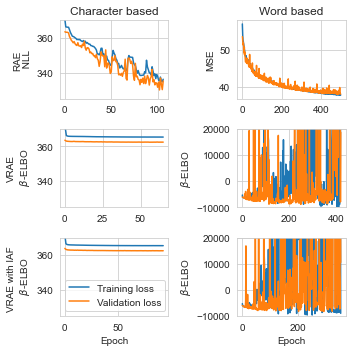

In [5]:
fig, axes =  plt.subplots( nrows=3, ncols=2, figsize=(5,5))

axes[0][0].plot(t_info_rae_c["training_loss"])
axes[0][0].plot(t_info_rae_c["validation_loss"])
axes[1][0].plot(t_info_vrae_c["training_loss"])
axes[1][0].plot(t_info_vrae_c["validation_loss"])
axes[2][0].plot(t_info_vrae_iaf_c["training_loss"],label='Training loss')
axes[2][0].plot(t_info_vrae_iaf_c["validation_loss"],label='Validation loss')
axes[0][1].plot(t_info_rae_w["training_loss"])
axes[0][1].plot(t_info_rae_w["validation_loss"])
axes[1][1].plot(t_info_vrae_w["training_loss"])
axes[1][1].plot(t_info_vrae_w["validation_loss"])
axes[2][1].plot(t_info_vrae_iaf_w["training_loss"])
axes[2][1].plot(t_info_vrae_iaf_w["validation_loss"])

axes[2][0].legend()

axes[0][0].set_ylim(325, 370)
axes[1][0].set_ylim(325, 370)
axes[2][0].set_ylim(325, 370)

axes[1][1].set_ylim(-10000, 20000)
axes[2][1].set_ylim(-10000, 20000)

axes[0][0].set_title("Character based")
axes[0][1].set_title("Word based")

axes[0][0].set_ylabel("RAE\n NLL")
axes[1][0].set_ylabel("VRAE\n $\\beta$-ELBO")
axes[2][0].set_ylabel("VRAE with IAF \n $\\beta$-ELBO")

axes[0][1].set_ylabel("MSE")
axes[1][1].set_ylabel("$\\beta$-ELBO")
axes[2][1].set_ylabel("$\\beta$-ELBO")

axes[2][0].set_xlabel("Epoch")
axes[2][1].set_xlabel("Epoch")

fig.tight_layout()
fig.savefig(figure_directory / "init_training.pdf")

## Out of distribution detection

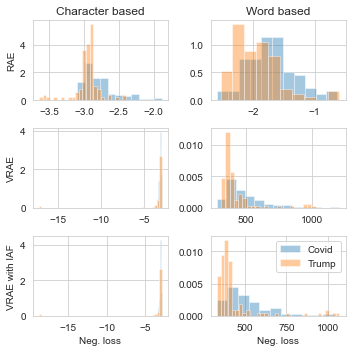

In [10]:
results =  torch.load(Path(".") / "reports" / "init_ood_results.pkl")

ll_in_distribution = results["ll_in_distribution"]
ll_out_of_distribution = results["ll_out_of_distribution"]
diagnostics_in_distribution = results["diagnostics_in_distribution"]
diagnostics_out_of_distribution = results["diagnostics_out_of_distribution"]

fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(5, 5))

axes[0][0].set_title("Character based")
axes[0][1].set_title("Word based")

axes[0][0].set_ylabel("RAE")
axes[1][0].set_ylabel("VRAE")
axes[2][0].set_ylabel("VRAE with IAF")

axes[2][0].set_xlabel("Neg. loss")
axes[2][1].set_xlabel("Neg. loss")


for i, model_type in enumerate(["rae", "vrae", "vrae_iaf"]):
    for j, domain in enumerate(["character", "word"]):
        
        ood_dist = ll_out_of_distribution[f"{domain}_{model_type}"]
        id_dist = ll_in_distribution[f"{domain}_{model_type}"]

        # Only considering obervations within a reasonable interval
        min_ood, max_ood = np.quantile(ood_dist,(0.005, 0.999)) 
        min_id, max_id = np.quantile(id_dist,(0.005, 0.999)) 

        ood_filtered = [x for x in ood_dist if x < max_ood and x > min_ood]
        id_filtered = [x for x in id_dist if x < max_id and x > min_id]

        sns.distplot(id_filtered, label="Covid", ax=axes[i][j], kde=False,
            norm_hist=True)
        sns.distplot(ood_filtered, label="Trump", ax=axes[i][j], kde=False,
            norm_hist=True)

plt.legend()
fig.tight_layout()

fig.savefig(figure_directory / "init_ood.pdf")

In [19]:
columns = pd.MultiIndex.from_product([["ELBO/loglik/neg. SE", "KL-div"], ["Covid", "Trump"]]) 
rows = pd.Index(["Word RAE", "Word VRAE", "Word IAF", "Char. RAE", "Char. VRAE", "Char. IAF"])

summary = pd.DataFrame(index=rows, columns=columns)

summary.loc[:, [['KL-div', 'Covid']]] = [
    np.NaN,
    np.mean(diagnostics_in_distribution['word_vrae']['kl']),
    np.mean(diagnostics_in_distribution['word_vrae_iaf']['kl']),
    np.NaN,
    np.mean(diagnostics_in_distribution['character_vrae']['kl']),
    np.mean(diagnostics_in_distribution['character_vrae_iaf']['kl']),
]

summary.loc[:, [['KL-div', 'Trump']]] = [
    np.NaN,
    np.mean(diagnostics_out_of_distribution['word_vrae']['kl']),
    np.mean(diagnostics_out_of_distribution['word_vrae_iaf']['kl']),
    np.NaN,
    np.mean(diagnostics_out_of_distribution['character_vrae']['kl']),
    np.mean(diagnostics_out_of_distribution['character_vrae_iaf']['kl']),
]

summary.loc[:, [["ELBO/loglik/neg. SE", 'Covid']]] = [
    np.mean(ll_in_distribution['word_rae']),
    np.mean(ll_in_distribution['word_vrae']),
    np.mean(ll_in_distribution['word_vrae_iaf']),
    np.mean(ll_in_distribution['character_rae']),
    np.mean(ll_in_distribution['character_vrae']),
    np.mean(ll_in_distribution['character_vrae_iaf']),
]

summary.loc[:, [["ELBO/loglik/neg. SE", 'Trump']]] = [
    np.mean(ll_out_of_distribution['word_rae']),
    np.mean(ll_out_of_distribution['word_vrae']),
    np.mean(ll_out_of_distribution['word_vrae_iaf']),
    np.mean(ll_out_of_distribution['character_rae']),
    np.mean(ll_out_of_distribution['character_vrae']),
    np.mean(ll_out_of_distribution['character_vrae_iaf']),
]

display(summary)

summary.to_latex(
    buf=table_directory / "init_summary.tex",
    caption="""
    Average fitness statistics for each model on the two test datasets. 
    The statistics are normalized with the sequence lengths. 
    Average value of KL term across each dataset also included.
    \\vspace{4}
    """, 
    label="tab:init-results", 
    na_rep="-", 
    float_format="%.3f" 
    )

ELBO/loglik/neg. SE                  KL-div            
                         Covid       Trump       Covid       Trump
Word RAE             -1.713076   -1.949076         NaN         NaN
Word VRAE           501.599514  436.928581  282.497292  285.650410
Word IAF            518.956194  449.798647  255.410958  246.986104
Char. RAE            -2.760999   -3.019517         NaN         NaN
Char. VRAE           -3.099791   -3.682670   -0.000271   -0.000364
Char. IAF            -3.097388   -3.743997   -0.002240   -0.006402

In [118]:
summary['KL-div']['Covid'].iloc[0] = 1

In [124]:
np.mean(diagnostics_out_of_distribution['word_vrae']['kl'])

288.5947186279297